# Temperatuur 2024

“The year 2024 is on track to be the warmest year on record” waarschuwt de WMO in zijn meest recente state of the climate update. “Warm” lijkt niet meteen het eerste woord dat hier in Vlaanderen geassocieerd wordt met het weerbeeld van 2024. In deze notebook checken we de open data om hier mee zicht op te krijgen

## Initialiseren

In [63]:
import matplotlib.pyplot as plt
import pandas as pd   
from openkmi.point_obs import Synop
from datetime import datetime, timedelta
import statsmodels.api as sm

plt.rcParams['font.family'] = 'MonoSpace'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [64]:
kmi = Synop()

## Data verzamelen

We downloaden de temperatuur voor Ukkel.

In [65]:
df = kmi.get_data('6447', parameter_list=['temp']).dropna()
df['month'] = df.index.month
df['year'] = df.index.year

## Aanvullen

Hier vullen we de data voor de rest van het jaar aan op basis van de gemiddelde waardes

In [66]:
# Bereken gemiddelde per maand
df_m_tmp = df[(df.index.year >= 1971) & (df.index.year <2001)].groupby('month').mean()['temp']
df_m_tmp.name = 'temp'

In [67]:
# Vul de dagen die dit jaar nog moeten komen aan met het gemiddelde en merge het resultaat om een output tot eind dit jaar te kunnen schatten.
df_rest_of_year = pd.DataFrame(index=pd.date_range(start=df.last_valid_index() + timedelta(hours=1), end='2025-01-01 00:00:00+00:00', freq='1H'))
df_rest_of_year['month'] = df_rest_of_year.index.month
df_rest_of_year['year'] = df_rest_of_year.index.year
df_rest_of_year = df_rest_of_year.merge(df_m_tmp, left_on=df_rest_of_year['month'], right_index=True).sort_index()
df = pd.concat([df, df_rest_of_year[['temp', 'month', 'year']]], axis=0)

In [68]:
# Bereken het gemiddelde per jaar voor de referentieperiode en trek het af van de jaarlijkse temperatuur
ref = df.groupby('year').mean()['temp'][range(1971,2001)].mean()
mean_ref = df.groupby('year').mean()['temp'] - ref
mean_ref = mean_ref.iloc[:-1]

# Plotten

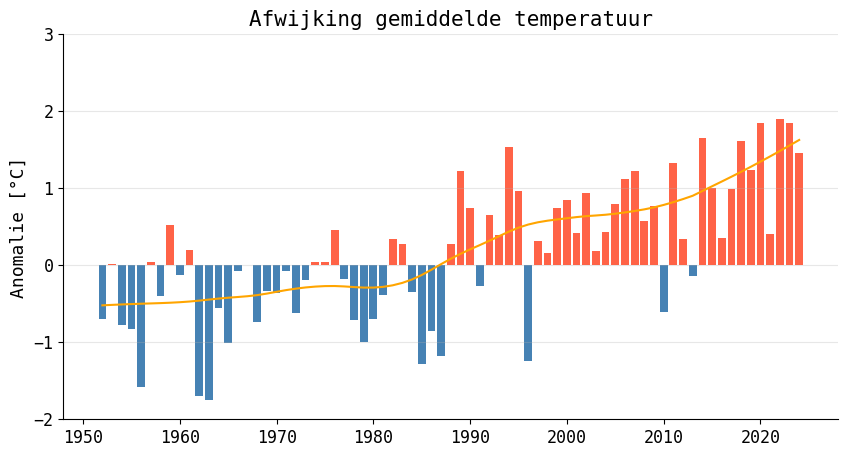

In [69]:
lowess = sm.nonparametric.lowess
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x= mean_ref[mean_ref>0].index.values, height=mean_ref[mean_ref>0].values, color='tomato')
ax.bar(x= mean_ref[mean_ref<0].index.values, height=mean_ref[mean_ref<0].values, color='steelblue')
w = lowess(mean_ref.values, mean_ref.index, frac=1./3)
ax.plot(w[:,0], w[:,1], color='orange')
ax.set_ylim(-2,3)
ax.set_title('Afwijking gemiddelde temperatuur')
ax.set_ylabel('Anomalie [°C]')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(axis='y', alpha=0.3)
plt.savefig('Temperatuur_v2024.png')